In [10]:
!pip install skyfield

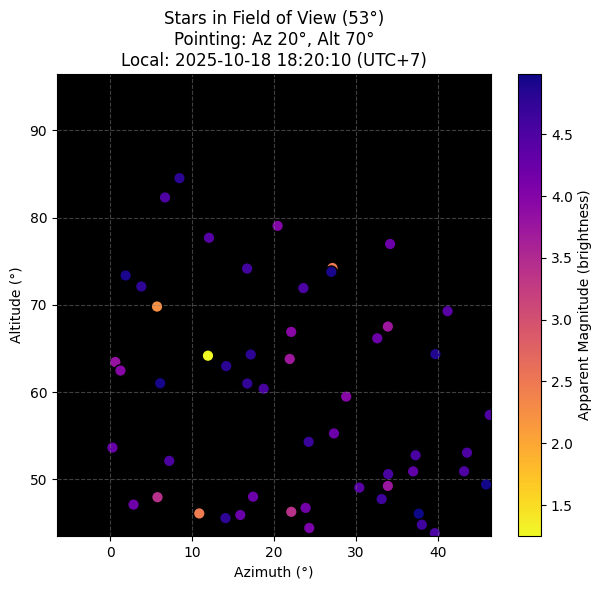

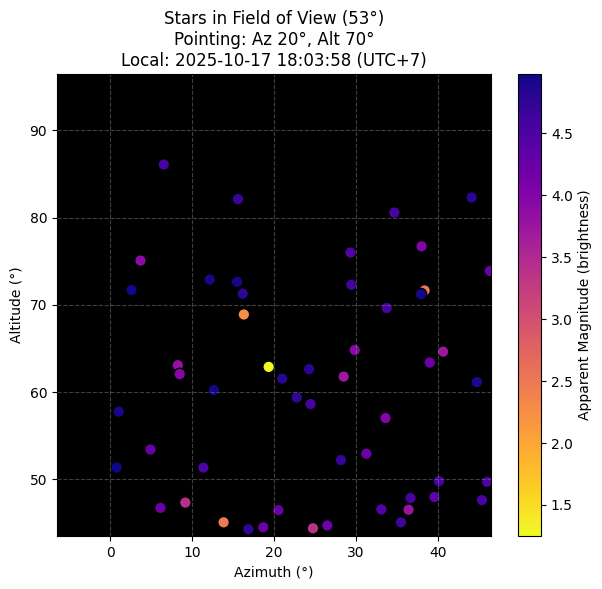

In [17]:
# pip install skyfield matplotlib numpy pytz

from skyfield.api import load, Star, wgs84
from skyfield.data import hipparcos
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np

# --- CONFIGURATION ---
latitude_deg = 20.25542983509747
longitude_deg = 105.95091543042761
elevation_m = 10
timezone = pytz.timezone("Asia/Bangkok")  # UTC+7 (Hanoi)

local_times = [
    "2025-10-18 18:20:10",
    "2025-10-17 18:03:58"
]

# Approximate field of view for a normal lens
fov_deg = 53

# Define directions camera might be pointing to
# (azimuth°, altitude°)
camera_directions = [
    (20, 70),    # East, high
]

# --- LOAD SKYFIELD DATA ---
ts = load.timescale()
planets = load('de421.bsp')
earth = planets['earth']

# Load Hipparcos catalog
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

# Assign common star names for the brightest ones
name_map = {
    32349: "Sirius", 30438: "Canopus", 24436: "Achernar", 37279: "Rigel", 27989: "Betelgeuse",
    7588: "Aldebaran", 91262: "Vega", 65474: "Arcturus", 24608: "Capella", 68702: "Spica",
    71683: "Alpha Centauri", 72607: "Hadar", 67464: "Antares", 113368: "Fomalhaut",
    11767: "Pollux", 21421: "Mirfak", 87937: "Altair", 71681: "Rigil Kentaurus"
}

bright_stars = df[df['magnitude'] < 5].copy()  # slightly more stars
bright_stars['name'] = bright_stars.index.map(name_map).fillna("")
stars = Star.from_dataframe(bright_stars)

# --- OBSERVER LOCATION ---
observer = earth + wgs84.latlon(latitude_deg, longitude_deg, elevation_m)

# --- LOOP THROUGH TIMES ---
for time_str in local_times:
    local_dt = timezone.localize(datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S"))
    utc_dt = local_dt.astimezone(pytz.utc)
    t = ts.from_datetime(utc_dt)

    # Observe all stars at that time
    astrometric = observer.at(t).observe(stars).apparent()
    alt, az, distance = astrometric.altaz()

    # Filter stars above horizon
    visible = alt.degrees > 0
    alt_visible = alt.degrees[visible]
    az_visible = az.degrees[visible]
    mags = bright_stars['magnitude'][visible]
    names = bright_stars['name'][visible]

    # --- LOOP OVER CAMERA DIRECTIONS ---
    for center_az, center_alt in camera_directions:
        half_fov = fov_deg / 2
        # Select stars within this FOV window
        in_view = (
            (np.abs((az_visible - center_az + 180) % 360 - 180) < half_fov) &
            (np.abs(alt_visible - center_alt) < half_fov)
        )

        if not np.any(in_view):
            continue

        plt.figure(figsize=(7, 6))
        sc = plt.scatter(
            az_visible[in_view], alt_visible[in_view],
            c=mags[in_view], cmap='plasma_r', s=70, edgecolor='k'
        )
        plt.colorbar(sc, label='Apparent Magnitude (brightness)')
        plt.xlabel('Azimuth (°)')
        plt.ylabel('Altitude (°)')
        plt.title(
            f"Stars in Field of View ({fov_deg}°)\n"
            f"Pointing: Az {center_az}°, Alt {center_alt}°\n"
            f"Local: {time_str} (UTC+7)"
        )
        plt.xlim(center_az - half_fov, center_az + half_fov)
        plt.ylim(center_alt - half_fov, center_alt + half_fov)
        plt.gca().set_facecolor('k')
        plt.grid(True, color='gray', linestyle='--', alpha=0.5)

        # Label brightest stars (magnitude < 1.5)
        for az, alt_, mag, name in zip(az_visible[in_view], alt_visible[in_view],
                                       mags[in_view], names[in_view]):
            if mag < 1.5 and name.strip():
                plt.text(az + 0.5, alt_ + 0.5, name,
                         color='white', fontsize=9, weight='bold')

        plt.show()